In [31]:
# back to project root
%cd ~/research

import os
import sys
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import yaml
from scipy import signal
import seaborn as sns

sys.path.append("src")
from utility.logger import logger
from utility.activity_loader import get_data_dirs, load_group
from utility.functions import moving_average
from utility.video import Capture, Writer, concat_field_with_frame
from visualize.group import GroupVisualizer
from visualize.individual import write_field as ind_write_field
from visualize.keypoint import write_frame as kps_write_frame

/raid6/home/yokoyama/research


In [2]:
room_num = "02"
surgery_num = "001"

In [3]:
cfg_path = "config/demo_config.yaml"
with open(cfg_path, "r") as f:
    cfg = yaml.safe_load(f)
with open(cfg["config_path"]["group"], "r") as f:
    grp_cfg = yaml.safe_load(f)
with open(grp_cfg["attention"]["object_path"], "r") as f:
    object_points = yaml.safe_load(f)[room_num][surgery_num]

In [4]:
field = cv2.imread("image/field.png")
visualizer = GroupVisualizer(["attention"])

In [5]:
data_dirs = []
for data_dir in get_data_dirs(room_num, surgery_num, "attention"):
    if "random" not in data_dir:
        data_dirs.append(data_dir)
    
print(data_dirs)

['data/02/001/attention/01', 'data/02/001/attention/02', 'data/02/001/attention/03', 'data/02/001/attention/04']


In [7]:
attention_dict = {}
for data_dir in data_dirs:
    print(data_dir)
    num = os.path.basename(data_dir)
    json_path = os.path.join(data_dir, ".json", "group.json")
    if os.path.exists(json_path):
        group = load_group(json_path, grp_cfg, field, logger, only_data_loading=True)
        attention_dict[num] = group.get("attention")

data/02/001/attention/01
data/02/001/attention/02
data/02/001/attention/03
data/02/001/attention/04


## attention score

In [41]:
def likelihood(object_point, attention_data, sigma=50):
    px = object_point[0]
    py = object_point[1]
    
    value_dict = {}
    for frame_num, data in tqdm(attention_data.items()):
        if frame_num not in value_dict:
            value_dict[frame_num] = {"values": [], "weights": []}
            
        for item in data:
            x, y = item["point"]
            val = item["value"]
            gauss = np.exp(-((x - px)**2 + (y - py)**2) / (2 * sigma ** 2))
        
            value_dict[frame_num]["values"].append(val)
            value_dict[frame_num]["weights"].append(gauss + 1e-10)
        
    means = {}
    for frame_num, value in value_dict.items():
        if len(value["values"]) > 0:
            means[frame_num] = np.average(value["values"], weights=value["weights"])
    
    return means

In [42]:
likelihoods = {}
for num, attention_data in attention_dict.items():
    for i, point in enumerate(object_points[num]):
        key = f"{num}_{i + 1}"
        likelihoods[key] = likelihood(point, attention_data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:00<00:00, 3277.22it/s]


## ヒストグラム、箱ひげ図

In [43]:
def boxplot(df_lst):
    fig = plt.figure(figsize=(5, 2))
    axs = [
        fig.add_axes((0.1, 0.1, 0.29, 0.85)),
        fig.add_axes((0.4, 0.1, 0.29, 0.85)),
        fig.add_axes((0.7, 0.1, 0.29, 0.85))
    ]

    for j in range(3):
        sns.boxplot(x='variable', y='value', data=df_lst[j], showfliers=False, ax=axs[j])
        axs[j].set_ylabel('')
        axs[j].set_xlabel('')
        axs[j].set_ylim((0, 1.5))

    axs[0].set_ylabel('Attention Score')
    axs[1].set_yticklabels([])
    axs[2].set_yticklabels([])

    # box_path = os.path.join(common.data_dir, 'image', opt, f'box_{room_num}_{date}.pdf')
    # fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    # fig.savefig(box_path)

In [44]:
def hist(df_lst, labels_lst):
    fig = plt.figure(figsize=(5, 2))
    axs = [
        fig.add_axes((0.06, 0.1, 0.26, 0.85)),
        fig.add_axes((0.39, 0.1, 0.26, 0.85)),
        fig.add_axes((0.72, 0.1, 0.26, 0.85))
    ]
    
    for j in range(3):
        sns.histplot(
            data=df_lst[j], x='value', hue='variable', bins=20, kde=True, ax=axs[j]
        )
        
        axs[j].set_ylabel('')
        axs[j].set_xlabel('')
        axs[j].legend(
            labels=labels_lst[j][::-1], fontsize=7, handlelength=0.5, handletextpad=0.2
        )

        # axs[j].set_xlabel('Attention Score')

    # box_path = os.path.join(common.data_dir, 'image', opt, f'hist_{room_num}_{date}.pdf')
    # fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    # fig.savefig(box_path)

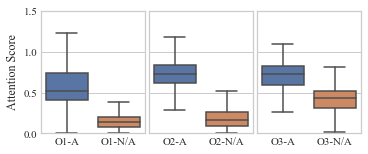

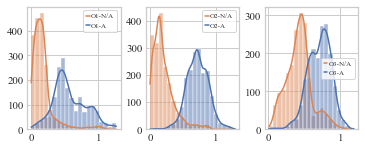

In [45]:
sns.set()
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in

df_lst = []
labels_lst = []
for i in range(3):
    data_dict = {}
    key1 = f"{i + 1:02d}_{1}"
    key2 = f"04_{i + 1}"
    data1 = list(likelihoods[key1].values())
    data2 = list(likelihoods[key2].values())

    label1 = f'O{i % 3 + 1}-A'
    label2 = f'O{i % 3 + 1}-N/A'
    labels = [label1, label2]
    labels_lst.append(labels)

    data_dict[label1] = data1
    data_dict[label2] = data2

    df = pd.DataFrame.from_dict(data_dict)
    df = pd.melt(df)
    df_lst.append(df)

boxplot(df_lst)
hist(df_lst, labels_lst)

In [46]:
from scipy import stats

In [47]:
for i in range(3):
    key1 = f"{i + 1:02d}_{1}"
    key2 = f"04_{i + 1}"
    data1 = np.array(list(likelihoods[key1].values()))
    data2 = np.array(list(likelihoods[key2].values()))

    w, p = stats.mannwhitneyu(data1, data2, alternative='greater', use_continuity=True)
    print(f"O_{i + 1}")
    print('Mann-Whitney U', f"statistic: {w:e}", f"p: {p:e}")

O_1
Mann-Whitney U statistic: 3.006085e+06 p: 0.000000e+00
O_2
Mann-Whitney U statistic: 3.146233e+06 p: 0.000000e+00
O_3
Mann-Whitney U statistic: 2.850249e+06 p: 0.000000e+00
